In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

import os.path as osp

In [2]:
file = osp.join('.', 'Videos',
                'Traffic IP Camera video.mp4')
cap = cv.VideoCapture(file)

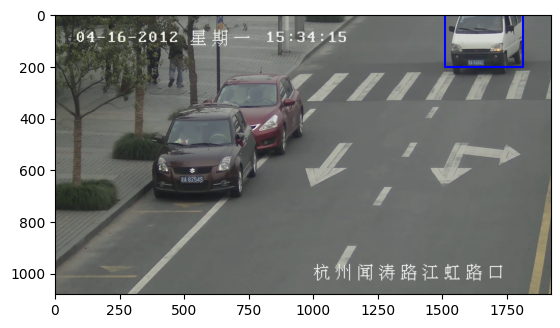

In [3]:
# frame with target
cap.set(cv.CAP_PROP_POS_FRAMES, 90)
_, frame = cap.read()
target = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
#Display the resulting frame
plt.imshow(target)

# setup initial location of window
init_x, init_y, w, h = 1510, 0, 300, 200
plt.plot([init_x, init_x + w, init_x + w, init_x, init_x],
         [init_y, init_y, init_y + h, init_y + h, init_y], 'b-')

In [4]:
# # take first frame of the video
# ret,frame = cap.read()

track_window = (init_x, init_y, w, h)

# set up the Region-Of-Interest for tracking
roi = frame[init_y:init_y+h, init_x:init_x+w]
hsv_roi =  cv.cvtColor(roi, cv.COLOR_BGR2HSV)
mask = cv.inRange(hsv_roi, np.array((0., 60.,32.)), np.array((180.,255.,255.)))
roi_hist = cv.calcHist([hsv_roi],[0],mask,[180],[0,180])
cv.normalize(roi_hist, roi_hist, 0, 255, cv.NORM_MINMAX)
pass

In [6]:
# Setup the termination criteria, either 10 iteration or move by at least 1 pt
term_crit = ( cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 1 )
count = 120
iter_count = 1
frame_len = int(cap.get(cv.CAP_PROP_FRAME_COUNT)) - count

prev_win = track_window
reset_iter = 0
frames = []

end = count + frame_len
while (count := count + iter_count) < end:
    cap.set(cv.CAP_PROP_POS_FRAMES, count)
    ret, frame = cap.read()
    if ret:
        hsv = cv.cvtColor(frame, cv.COLOR_BGR2HSV)
        dst = cv.calcBackProject([hsv],[0],roi_hist,[0,180],1)
        # apply meanshift to get the new location
        ret, track_window = cv.meanShift(dst, track_window, term_crit)
        # Draw it on image
        x, y, w, h = track_window
        img2 = cv.rectangle(frame, (x,y), (x+w,y+h), 255,2)
        # plt.figure()
        # plt.imshow(img2)
        frames.append(img2)
        if abs(prev_win[0] - x + prev_win[1] - y) <= 3:
            reset_iter += 1
            if reset_iter > 20:
                track_window = (init_x, init_y, w, h)
                reset_iter = 0
        else: reset_iter = 0
        prev_win = track_window
    else: break

In [12]:
fourcc = cv.VideoWriter_fourcc(*'mp4v')  # macOS: MP4V | windows: DIVX
out = cv.VideoWriter(osp.join('.', 'Output', 'output.mp4'), fourcc, 20.0, (1920, 1080))
for temp in frames:
    out.write(temp)
out.release()
